In [22]:
# policy_crud_agent.py
from __future__ import annotations
from typing import Literal, TypedDict, Dict, Any, Optional, List, Union
import os, json, time

from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv(".env")

# LangChain / LangGraph
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt



In [23]:
# ============== Config ============
LLM_MODEL = os.getenv("LLM_MODEL", "openai:gpt-4.1")
DELETE_REQUIRES_HITL = os.getenv("DELETE_REQUIRES_HITL", "true").lower() == "true"


In [24]:

# ============== Estado ============
class PolicyState(TypedDict, total=False):
    email_input: str          # correo crudo
    messages: list            # chat history para el agent
    intent: Dict[str, Any]    # intención extraída
    hitl_resolved: bool       # bandera tras aprobación humana
    logs: List[str]           # trazas


In [25]:

def _log(s: PolicyState, msg: str):
    s.setdefault("logs", []).append(msg)
    return s

In [26]:

# Escalares permitidos (tienen 'type' en el schema)
JsonScalar = Union[str, int, float, bool, None]

class KVPair(BaseModel):
    key: str = Field(..., min_length=1, description="Nombre del campo")
    value: JsonScalar = Field(..., description="Valor escalar (usa string si es objeto/lista)")
    model_config = {"extra": "forbid"}  # => additionalProperties: false

class PolicyIntent(BaseModel):
    action: Literal["create", "update", "delete", "none"] = Field(..., description="Operación objetivo")
    policy_id: Optional[str] = Field(None, description="ID de póliza (para update/delete)")
    customer_id: Optional[str] = Field(None, description="ID cliente (para create)")
    fields: List[KVPair] = Field(default_factory=list, description="Pares key/value")
    confidence: float = Field(0.0, ge=0, le=1, description="Confianza (0-1)")
    model_config = {"extra": "forbid"}  # => cierra el objeto superior

In [27]:

base_llm = init_chat_model(LLM_MODEL, temperature=0.0)
extract_llm = base_llm.with_structured_output(PolicyIntent)


In [28]:

def extract_intent_node(state: PolicyState) -> PolicyState:
    email_text = state["email_input"]
    intent = extract_llm.invoke([
        {"role": "system", "content": "Eres un analista de pólizas. Dado un correo, extrae la intención de CRUD de pólizas."},
        {"role": "user", "content": email_text}
    ])

    # ✅ convertir List[KVPair] -> Dict[str, Any] para mantener tu contrato interno
    intent_dict = intent.model_dump()
    fields_dict = {kv["key"]: kv["value"] for kv in intent_dict.get("fields", [])}
    intent_dict["fields"] = fields_dict

    state["intent"] = intent_dict  
    _log(state, f"intent={state['intent']}")
    # Sembramos contexto para el agent prebuild (le damos los args ya parseados)
    sys_context = (
        "CONTEXT | Intent parsed from email:\n"
        f"- action: {intent.action}\n"
        f"- policy_id: {intent.policy_id}\n"
        f"- customer_id: {intent.customer_id}\n"
        f"- fields: {json.dumps(intent.fields, ensure_ascii=False)}\n"
        f"- confidence: {intent.confidence}\n\n"
        "Always VERIFY the intent first using `verify_policy_info` with these values. "
        "Then, if valid, call the corresponding MCP tool: "
        "`mcp_create_policy` (create), `mcp_update_policy` (update), or `mcp_delete_policy` (delete). "
        "If required data is missing, call `mcp_request_missing_info`."
    )
    state["messages"] = [{"role":"system","content": sys_context}]
    return state

In [29]:


# ============== MCP-like Tools (simuladas) ==============
@tool
def verify_policy_info(action: Literal["create","update","delete"], policy_id: Optional[str]=None,
                       customer_id: Optional[str]=None, fields: Optional[Dict[str, Any]]=None) -> Dict[str, Any]:
    """
    Verifica que la intención tenga datos mínimos para ejecutar la acción.
    Regresa {ok: bool, missing: [..], normalized_fields: {...}}.
    """
    missing = []
    fields = fields or {}
    if action == "create":
        if not customer_id: missing.append("customer_id")
        if not fields: missing.append("fields")
    elif action == "update":
        if not policy_id: missing.append("policy_id")
        if not fields: missing.append("fields")
    elif action == "delete":
        if not policy_id: missing.append("policy_id")
    else:
        missing.append("action_valid")

    ok = len(missing) == 0
    return {"tool": "verify_policy_info", "ok": ok, "missing": missing, "normalized_fields": fields}

@tool
def mcp_request_missing_info(missing: List[str], note: Optional[str]=None) -> Dict[str, Any]:
    """
    Solicita información faltante (simulado). En producción dispararía un flujo HITL o correo de retorno.
    """
    return {"tool":"mcp_request_missing_info", "status":"REQUESTED", "missing": missing, "note": note or ""}

@tool
def mcp_create_policy(customer_id: str, fields: Dict[str, Any]) -> Dict[str, Any]:
    """Crea una póliza (simulado)."""
    time.sleep(0.1)
    fake_id = f"P{int(time.time())}"
    return {"tool":"mcp_create_policy", "status":"CREATED", "policy_id": fake_id, "customer_id": customer_id, "fields": fields}

@tool
def mcp_update_policy(policy_id: str, fields: Dict[str, Any]) -> Dict[str, Any]:
    """Actualiza una póliza (simulado)."""
    time.sleep(0.05)
    return {"tool":"mcp_update_policy", "status":"UPDATED", "policy_id": policy_id, "fields": fields}

@tool
def mcp_delete_policy(policy_id: str) -> Dict[str, Any]:
    """Elimina una póliza (simulado) — debe pasar por HITL previo si está habilitado."""
    time.sleep(0.05)
    return {"tool":"mcp_delete_policy", "status":"DELETED", "policy_id": policy_id}

TOOLS = [
    verify_policy_info,
    mcp_request_missing_info,
    mcp_create_policy,
    mcp_update_policy,
    mcp_delete_policy,
]



In [ ]:

# ============== Agente prebuild (React Agent) ==============
AGENT_SYSTEM_PROMPT = """\
Eres un agente de pólizas.
Objetivo:
1) Verificar datos con `verify_policy_info` usando SIEMPRE los valores del CONTEXT.
2) Si faltan datos -> `mcp_request_missing_info`.
3) Si está todo bien -> ejecutar UNA de:
   - create -> `mcp_create_policy`
   - update -> `mcp_update_policy`
   - delete -> `mcp_delete_policy`
4) Finaliza llamando `Done` (si existe en tu entorno) o entregando una respuesta clara.
Política de seguridad:
- Si la acción es DELETE y no hay aprobación humana previa, no ejecutes el borrado: solicita aprobación (HITL).
Estilo: conciso y operacional.
"""

In [31]:
# === Config (arriba, junto a LLM_MODEL) ===
SENSITIVE_HITL_ACTIONS = {
    a.strip() for a in os.getenv("SENSITIVE_HITL_ACTIONS", "delete,update").split(",")
}


In [32]:
import re
from typing import List

# Campos críticos por acción
REQUIRED_BY_ACTION = {
    "create": ["customer_id", "fields"],
    "update": ["policy_id", "fields"],
    "delete": ["policy_id"],
}

def list_missing(intent: dict) -> List[str]:
    action = (intent or {}).get("action") or "none"
    if action == "none":
        return ["action"]
    req = REQUIRED_BY_ACTION.get(action, [])
    return [k for k in req if not (intent.get(k) or (intent.get(k) == 0))]

def need_clarification(state: "PolicyState") -> str:
    """Devuelve 'clarify' si faltan campos, si no 'proceed'."""
    missing = list_missing(state.get("intent", {}))
    return "clarify" if missing else "proceed"

def extract_sender(email_text: str) -> str:
    """Busca 'From: Nombre <correo>' y devuelve el correo si existe."""
    m = re.search(r"^From:\s*.*?<([^>]+)>", email_text, flags=re.IGNORECASE | re.MULTILINE)
    if m:
        return m.group(1).strip()
    # fallback simple: línea From: foo@bar
    m2 = re.search(r"^From:\s*([^\s]+@[^\s]+)", email_text, flags=re.IGNORECASE | re.MULTILINE)
    return m2.group(1).strip() if m2 else ""

def extract_subject(email_text: str) -> str:
    m = re.search(r"^Subject:\s*(.+)$", email_text, flags=re.IGNORECASE | re.MULTILINE)
    return m.group(1).strip() if m else "Tu solicitud de póliza"

def build_clarify_body(missing: List[str]) -> str:
    prompts = {
        "action": "¿Qué acción deseas realizar sobre la póliza? (create / update / delete)",
        "policy_id": "¿Nos confirmas el número/ID de la póliza a gestionar?",
        "customer_id": "¿Cuál es el ID del cliente para crear la póliza?",
        "fields": "¿Qué campos debemos crear/actualizar? (p. ej.: status, premium, start_date)",
    }
    # Pedimos todo lo faltante en un solo correo (breve y ordenado)
    lines = ["¡Hola! Para avanzar con tu solicitud necesitamos aclarar:"]
    for k in missing:
        lines.append(f"- {prompts.get(k, f'Por favor indícanos: {k}')}")
    lines.append("\nGracias, quedo atento(a).")
    return "\n".join(lines)


In [33]:
# === Tool para enviar email de aclaración (simulado) ===
from langchain.tools import tool

@tool
def send_email(to: str, subject: str, body: str) -> dict:
    """
    Envía un email (simulado). En producción, integrarlo con tu SMTP/API.
    """
    print(f"[send_email] to={to} subject={subject}\n{body}\n")
    return {"tool": "send_email", "status": "SENT", "to": to, "subject": subject}


In [34]:
def clarify_by_email_node(state: "PolicyState") -> "PolicyState":
    intent = state.get("intent", {}) or {}
    missing = list_missing(intent)
    if not missing:
        return state  # nada que aclarar

    to = extract_sender(state.get("email_input", "")) or ""
    subj = "Re: " + extract_subject(state.get("email_input", "Tu solicitud de póliza"))
    body = build_clarify_body(missing)

    # Llamamos el tool de envío (sin interrumpir el grafo)
    _ = send_email.invoke({"to": to or "usuario@desconocido", "subject": subj, "body": body})

    _log(state, f"clarification_email_sent to={to or 'unknown'} missing={missing}")
    state["clarification_sent"] = True
    # Fin del flujo: el usuario responderá por email y su respuesta llegará como NUEVO email al pipeline
    return state


In [35]:
def hitl_gate_node(state: "PolicyState") -> "PolicyState":
    """Si la acción es sensible (delete/update) y no ha sido aprobada internamente, dispara HITL (no correo)."""
    intent = state.get("intent", {}) or {}
    action = (intent.get("action") or "").lower()
    if action in SENSITIVE_HITL_ACTIONS and not state.get("hitl_resolved"):
        # Aquí SÍ usamos HITL interno (aprobación de supervisor). No es email al usuario.
        # Importante: interrupt solo acepta un argumento posicional.
        decision = interrupt({"type": "HITL_POLICY_APPROVAL_INTERNAL", "action": action, "intent": intent})
        # Si reanudan devolviendo, por ejemplo, {"approved": true}, puedes setear:
        if isinstance(decision, dict) and decision.get("approved") is True:
            state["hitl_resolved"] = True
            _log(state, f"hitl_internal_approved action={action}")
        else:
            _log(state, f"hitl_internal_rejected action={action}")
            # Puedes cortar el flujo si no aprueban:
            # raise RuntimeError("HITL interno rechazó la operación.")
    return state


In [ ]:
def build_prebuilt_agent():
    model = init_chat_model(LLM_MODEL, temperature=0.0)
    # create_react_agent acepta un modelo LangChain y la lista de tools
    agent = create_react_agent(model, TOOLS, prompt=AGENT_SYSTEM_PROMPT)
    return agent

policy_agent = build_prebuilt_agent()




In [37]:
def build_policy_crud_graph():
    g = StateGraph(PolicyState)
    g.add_node("extract_intent", extract_intent_node)
    g.add_node("clarify_by_email", clarify_by_email_node)   # <- NUEVO
    g.add_node("hitl_gate", hitl_gate_node)
    g.add_node("policy_agent", policy_agent)

    g.add_edge(START, "extract_intent")

    # Si faltan datos → enviamos email y terminamos. Si está completo → seguimos a HITL interno (si aplica).
    g.add_conditional_edges(
        "extract_intent",
        need_clarification,
        {"clarify": "clarify_by_email", "proceed": "hitl_gate"}
    )

    # Tras aclarar por email, TERMINA el flujo (no reanudamos)
    g.add_edge("clarify_by_email", END)

    g.add_edge("hitl_gate", "policy_agent")
    g.add_edge("policy_agent", END)

    return g.compile()


In [38]:
policy_crud_graph = build_policy_crud_graph()

# ============== Utilidad: resolver HITL en demo ==============
def resolve_hitl_and_continue(graph, state: PolicyState, approved: bool, note: str="") -> PolicyState:
    """
    Marca aprobación humana para DELETE (u otros flujos) y re-invoca.
    """
    state["hitl_resolved"] = bool(approved)
    state.setdefault("messages", []).append({"role":"system","content": f"HITL: delete approved={approved}. {note}"})
    return graph.invoke(state)

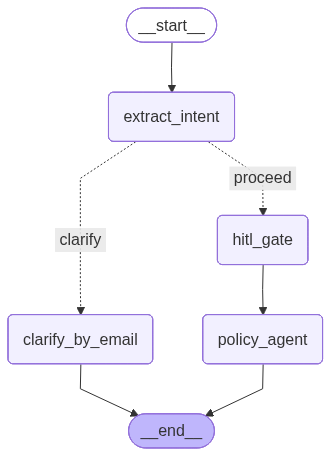

In [39]:
from email_assistant.utils import show_graph
show_graph(policy_crud_graph)

In [40]:
email_delete = """From: Maria <maria@acme.com>
To: Polizas <polizas@bank.com>
Subject: Solicitud de eliminación
Body:
Por favor eliminen la póliza . Ya no deseo continuar. Gracias.
"""

In [41]:
PolicyState = {"email_input": email_delete}

In [42]:
policy_crud_graph.invoke({"email_input": email_delete})

[send_email] to=maria@acme.com subject=Re: Solicitud de eliminación
¡Hola! Para avanzar con tu solicitud necesitamos aclarar:
- ¿Nos confirmas el número/ID de la póliza a gestionar?

Gracias, quedo atento(a).



{'email_input': 'From: Maria <maria@acme.com>\nTo: Polizas <polizas@bank.com>\nSubject: Solicitud de eliminación\nBody:\nPor favor eliminen la póliza . Ya no deseo continuar. Gracias.\n',
 'messages': [{'role': 'system',
   'content': 'CONTEXT | Intent parsed from email:\n- action: delete\n- policy_id: None\n- customer_id: None\n- fields: []\n- confidence: 0.7\n\nAlways VERIFY the intent first using `verify_policy_info` with these values. Then, if valid, call the corresponding MCP tool: `mcp_create_policy` (create), `mcp_update_policy` (update), or `mcp_delete_policy` (delete). If required data is missing, call `mcp_request_missing_info`.'}],
 'intent': {'action': 'delete',
  'policy_id': None,
  'customer_id': None,
  'fields': {},
  'confidence': 0.7},
 'logs': ["intent={'action': 'delete', 'policy_id': None, 'customer_id': None, 'fields': {}, 'confidence': 0.7}",
  "clarification_email_sent to=maria@acme.com missing=['policy_id']"]}